In [1]:
import ee
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geetools
import eemont
import geemap
from ee_extra.TimeSeries.core import getTimeSeriesByRegion
import geopandas as gpd
from shapely.geometry import shape

from plot_ee_fctns import get_image_index, box_around_point, mask_other, initialise_comparison
from masks import mask_MODIS_clouds, MODIS_Mask_QC, mask_s2_clouds, mask_s2_clouds_collection, csPlus_mask_collection
import masks

import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

#adm1_shapes = list(shpreader.Reader('gadm41_DEU_1/gadm41_DEU_1.shp').geometries())
# Path to the private key file
key_path = 'Access/ee-martinparker637-e68fde65abb4.json'

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=['https://www.googleapis.com/auth/earthengine'])

# Initialize Earth Engine with the service account credentials
ee.Initialize(credentials)
root_directory = ''

In [35]:
def count_reducer(img):
    return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=160, bestEffort=True)
def percentile_reducer(img):
    return img.reduceResolution(ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=800, bestEffort=True)
def addNDVI(image, bands = ['sur_refl_b01', 'sur_refl_b02']):
    ndvi = image.normalizedDifference(bands).rename('NDVI')
    return image.addBands([ndvi])

In [36]:
def compare_WC_MODIS(coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1:4],
                      country = 'DE', crop_type = 'M', year = 2021, root_directory = '', reducer_code = 'median',
                            buffer_size = 1500, mask_scale = 10, count_threshold = 0,
                            savename = False, title = 'MODIS NDVI 250m scale with\nWorldCereal Maize fields Kenya'):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, ax = plt.subplots(1, 1, figsize = (6, 9))
    first_coord = True
    for coord_index in range(1):
        #ax = axs[coord_index]
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
        if mask_scale > scale + 50:
            crop = count_reducer(crop).gt(count_threshold)
        crop = crop.updateMask(crop)
        region = crop.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))
        IC, vectors = initialise_comparison(instrument = "MODIS/061/MOD09GQ", coord = coord, 
                                        country = country, crop_type = crop_type, 
                                        year = year, root_directory = root_directory,
                                       spectral_indices = ['sur_refl_b01', 'sur_refl_b02'], indices = False)
        IC = IC.map(addNDVI)
        img2ndImage=get_image_index(IC, 1)
        img2ndImage.geetools.plot(bands = ['NDVI'], ax = ax, 
                                  region=region,cmap="viridis")
        WC_vectors.geetools.plot(ax=ax, property = 'mask_used', cmap="Reds")
        cb = fig.colorbar(ax.images[0], aspect = 10, fraction= 0.07)
        cb.set_label(label="NDVI", size=20)
        ax.set_title(title, fontsize = 25)
        ax.tick_params(labelsize = 20)
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

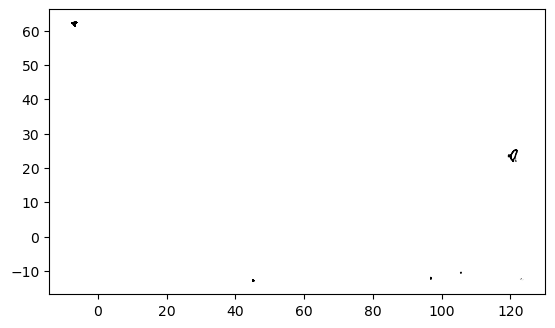

In [3]:


# Load GADM0, limit to 50 countries to keep it manageable
fc = ee.FeatureCollection("FAO/GAUL/2015/level0").limit(10)

# Get GeoJSON from EE
geojson = fc.getInfo()

# Extract boundaries from each feature geometry
boundaries = []
for feature in geojson['features']:
    geom = shape(feature['geometry'])
    boundary = geom.boundary  # get the polygon boundary as a LineString or MultiLineString
    boundaries.append(boundary)

# Create GeoDataFrame from boundaries
gdf_boundaries = gpd.GeoDataFrame(geometry=boundaries)

# Plot boundaries only
ax = gdf_boundaries.plot(color='black', linewidth=1)
plt.show()

In [29]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def plot_WC_MODIS_KE(crop_type = 'M', root_directory = '', count_threshold = 500,
                  mask_scale = 10, original_scale = 10, savename = False):
    font_size = 20
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    shapefile_codes = {'Germany': 'DEU',
                       'Kenya': 'KEN'}
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, axs = plt.subplots(1, 2, figsize = (10, 20))
    country_feat = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Kenya'))

    # Get GeoJSON from EE
    geojson = country_feat.getInfo()
    #print(geojson['features'][0])
    # Extract boundaries from each feature geometry
    boundaries = []
    for feature in geojson['features'][0]['geometry']['geometries']:
        geom = shape(feature)
        #boundary = geom.boundary  # get the polygon boundary as a LineString or MultiLineString
        if geom.geom_type in ['Polygon', 'MultiPolygon']:
            boundaries.append(geom.boundary)
    
    # Create GeoDataFrame from boundaries
    gdf_boundaries = gpd.GeoDataFrame(geometry=boundaries)
    #print(gdf_boundaries)
    # Plot boundaries only
    gdf_boundaries.plot(color='black', linewidth=1, ax=axs[0])
    gdf_boundaries.plot(color='black', linewidth=1, ax=axs[1])
    
    ax = axs[0]
    feature = country_feat.first()
    geometry = feature.geometry()

    location = ee.Feature(ee.List(country_feat.toList(999)).get(0)).geometry()

    maize_filter = ee.Filter.eq('season', season_codes[crop_type])#.Or(ee.Filter.eq('season', 'tc-maize-second'))
    world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(maize_filter)
    world_cereals = world_cereals.map(mask_other)
    crop = world_cereals.mosaic().select('classification')#.gt(0)
    scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
    print(scale)
    crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
    crop = crop.updateMask(crop).clip(location)
    if mask_scale > scale + 50:
        crop = count_reducer(crop)/130#.gt(count_threshold)
    print('prepare to plot!')
    #country_feat.filterBounds(location).geetools.plot(ax=ax, boundaries = True)
    crop.geetools.plot(bands = ['classification'], ax = ax, region=location,
                       crs = world_cereals.first().projection().getInfo()['crs'],
                       cmap="Oranges", scale = mask_scale/100000)
    ax.set_title('Location of maize\naccording to WorldCereal', fontsize = font_size)
    ax.images[0].set_clim(0, 1)

    ax = axs[1]
    MODIS_LC = ee.ImageCollection('MODIS/061/MCD12Q1').select('LC_Type1')
    MODIS_LC = MODIS_LC.filterDate('2020-01-01', '2020-12-31').mosaic()
    cMap = ListedColormap(['darkgreen' for count in range(5)] + ['goldenrod', 'goldenrod', 'yellow', 'yellow', 'greenyellow', 'turquoise', 'red', 'grey', 'red', 'white', 'white', 'navy'])
    MODIS_LC.geetools.plot(bands = ['LC_Type1'], ax = ax, region=location,
                       crs = world_cereals.first().projection().getInfo()['crs'],
                       cmap= cMap, scale = mask_scale/100000)
    ax.set_title('Land cover classes from MODIS', fontsize = font_size)
    color_code = {'darkgreen':'Forest', 'goldenrod': 'Shrubland', 'yellow': 'Savannah', 
                  'greenyellow': 'Grassland', 'turquoise': 'Wetland', 'red': 'Cropland', 'grey': 'Urban', 'white': 'Rocky', 'navy': 'Water'}
    handles = []
    for color in ['darkgreen', 'goldenrod', 'yellow', 'greenyellow', 'turquoise', 'red', 'grey', 'white', 'navy']:
        patch = mpatches.Patch(color=color, label=color_code[color])
        handles.append(patch)
    plt.legend(handles=handles, bbox_to_anchor = [1.4, 0.7])
    fig.suptitle('Land cover in Kenya', fontsize = font_size + 5, y=0.65)
    fig.tight_layout(w_pad = 5)
    cb = fig.colorbar(axs[0].images[0], aspect = 10, fraction= 0.07)
    cb.set_label(label="Maize density", size=font_size)
    #fig.colorbar(im, cax=cbar_ax)
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

9.276631250052876
prepare to plot!


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(
/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


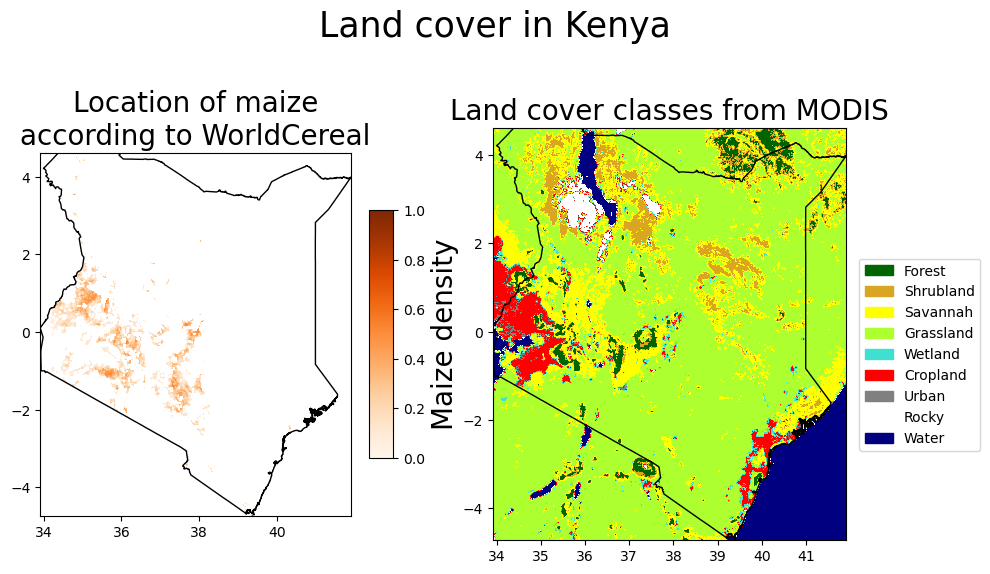

In [30]:
plot_WC_MODIS_KE(mask_scale = 1000, count_threshold = 0)

In [77]:
def plot_WC_DE_KE(crop_type = 'M', root_directory = '', count_threshold = 500,
                  mask_scale = 10, original_scale = 10, savename = False):
    font_size = 20
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    shapefile_codes = {'Germany': 'DEU',
                       'Kenya': 'KEN'}
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, axs = plt.subplots(1, 2, figsize = (10, 20))
    for country_ind, country in enumerate(['Kenya', 'Germany']):
        #if country == 'Kenya':
        #    continue
        ax = axs[country_ind]
        country_feat = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level0').filter(ee.Filter.eq('ADM0_NAME', country))

        # Get GeoJSON from EE
        geojson = country_feat.getInfo()
        #print(geojson['features'][0])
        # Extract boundaries from each feature geometry
        boundaries = []
        for feature in geojson['features'][0]['geometry']['geometries']:
            geom = shape(feature)
            #boundary = geom.boundary  # get the polygon boundary as a LineString or MultiLineString
            if geom.geom_type in ['Polygon', 'MultiPolygon']:
                boundaries.append(geom.boundary)
        
        # Create GeoDataFrame from boundaries
        gdf_boundaries = gpd.GeoDataFrame(geometry=boundaries)
        #print(gdf_boundaries)
        # Plot boundaries only
        gdf_boundaries.plot(color='black', linewidth=1, ax=ax)
        
        feature = country_feat.first()
        geometry = feature.geometry()

        location = ee.Feature(ee.List(country_feat.toList(999)).get(0)).geometry()

        maize_filter = ee.Filter.eq('season', season_codes[crop_type])#.Or(ee.Filter.eq('season', 'tc-maize-second'))
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(maize_filter)
        world_cereals = world_cereals.map(mask_other)
        crop = world_cereals.mosaic().select('classification')#.gt(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        print(scale)
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
        crop = crop.updateMask(crop).clip(location)
        if mask_scale > scale + 50:
            crop = count_reducer(crop)/100#.gt(count_threshold)
        print('prepare to plot!')
        #country_feat.filterBounds(location).geetools.plot(ax=ax, boundaries = True)
        crop.geetools.plot(bands = ['classification'], ax = ax, region=location,
                           crs = world_cereals.first().projection().getInfo()['crs'],
                           cmap="Oranges", scale = mask_scale/100000)
        ax.set_title(country, fontsize = font_size)
        ax.images[0].set_clim(0, 1)
    fig.suptitle('Spatial density of maize based on\nWorldCereal crop type mask', fontsize = font_size, y=0.67)
    fig.tight_layout()
    cb = fig.colorbar(axs[1].images[0], aspect = 10, fraction= 0.07)
    cb.set_label(label="Proportion of pixels with maize", size=font_size)
    #fig.colorbar(im, cax=cbar_ax)
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

9.276631250052876
prepare to plot!


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


9.276631250052876
prepare to plot!


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


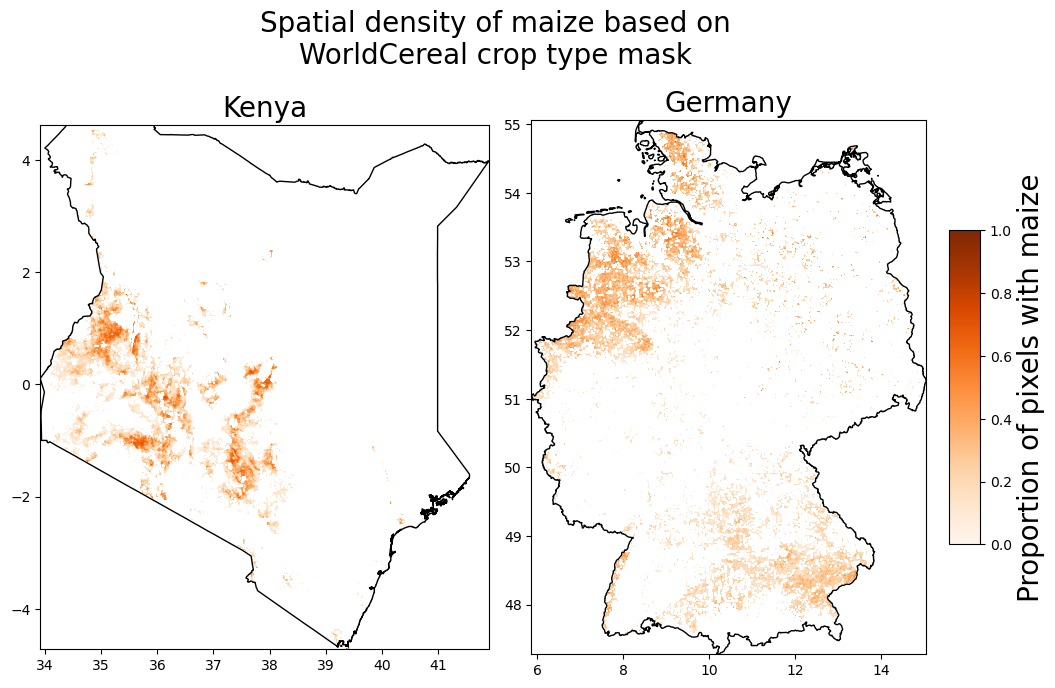

In [78]:
plot_WC_DE_KE(mask_scale = 1000, count_threshold = 0, savename = 'Plots/maize_maps.png')

In [100]:
from shapely.geometry import shape, GeometryCollection
def plot_WC_DE_KE(crop_type = 'M', root_directory = '', count_threshold = 500,
                  mask_scale = 10, original_scale = 10, savename = False):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    shapefile_codes = {'Germany': 'DEU',
                       'Kenya': 'KEN'}
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, axs = plt.subplots(1, 2, figsize = (10, 20))
    for country_ind, country in enumerate(['Kenya', 'Germany']):
        country_feat = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level0').filter(ee.Filter.eq('ADM0_NAME', country))
        # Initialize EE
        # Convert to GeoJSON (only safe for small FCs)
        geojson = country_feat.getInfo()

        # Extract geometries using shapely
        features = geojson['features']
        geometries = [shape(f['geometry']) for f in features]

        # Extract and flatten geometries
        def extract_geometries(geom):
            """
            Recursively extract geometries from GeometryCollections and normal shapes.
            Returns a flat list of shapely geometries.
            """
            s = shape(geom)
            if isinstance(s, GeometryCollection):
                return [g for part in s.geoms for g in extract_geometries(part)]
            else:
                return [s]
        
        all_geometries = []
        for f in features:
            try:
                geoms = extract_geometries(f['geometry'])
                all_geometries.extend(geoms)
            except Exception as e:
                print(f"Skipping feature due to error: {e}")
        # Plot manually
        fig, ax = plt.subplots()
        first = True
        for geom in all_geometries:
            if first == True:
                try:
                    if geom.geom_type == "Polygon":
                        x, y = geom.exterior.xy
                        ax.plot(x, y)
                        first = False
                    elif geom.geom_type == "MultiPolygon":
                        for part in geom.geoms:
                            x, y = part.exterior.xy
                            ax.plot(x, y)
                    elif geom.geom_type == "LineString":
                        continue
                    elif geom.geom_type == "Point":
                        continue
                except Exception as e:
                    print(f"Skipping geometry due to error: {e}")
        
        # Only set aspect ratio if bounds are valid
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xspan = abs(xlim[1] - xlim[0])
        yspan = abs(ylim[1] - ylim[0])
        
        if all(map(lambda v: v > 0 and v != float('inf'), [xspan, yspan])):
            ax.set_aspect('equal')

        else:
            print("Skipping aspect ratio setting: invalid geometry bounds")

        location = ee.Feature(ee.List(country_feat.toList(999)).get(0)).geometry()
        ax = axs[country_ind]
        maize_filter = ee.Filter.eq('season', season_codes[crop_type]).Or(ee.Filter.eq('season', 'tc-maize-second'))
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(maize_filter)
        world_cereals = world_cereals.map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        print(scale)
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
        crop = crop.updateMask(crop).clip(location)
        if mask_scale > scale + 50:
            crop = count_reducer(crop).gt(count_threshold)
        print('prepare to plot!')
        country_feat.filterBounds(location).geetools.plot(ax=ax, boundaries = True)
        crop.geetools.plot(bands = ['classification'], ax = ax, region=location,
                           crs = world_cereals.first().projection().getInfo()['crs'],
                           cmap="viridis", scale = mask_scale/100000)
        fig.tight_layout()
        if savename != False:
            fig.savefig(savename, bbox_inches = 'tight')

9.276593436772073
prepare to plot!


ValueError: aspect must be finite and positive 

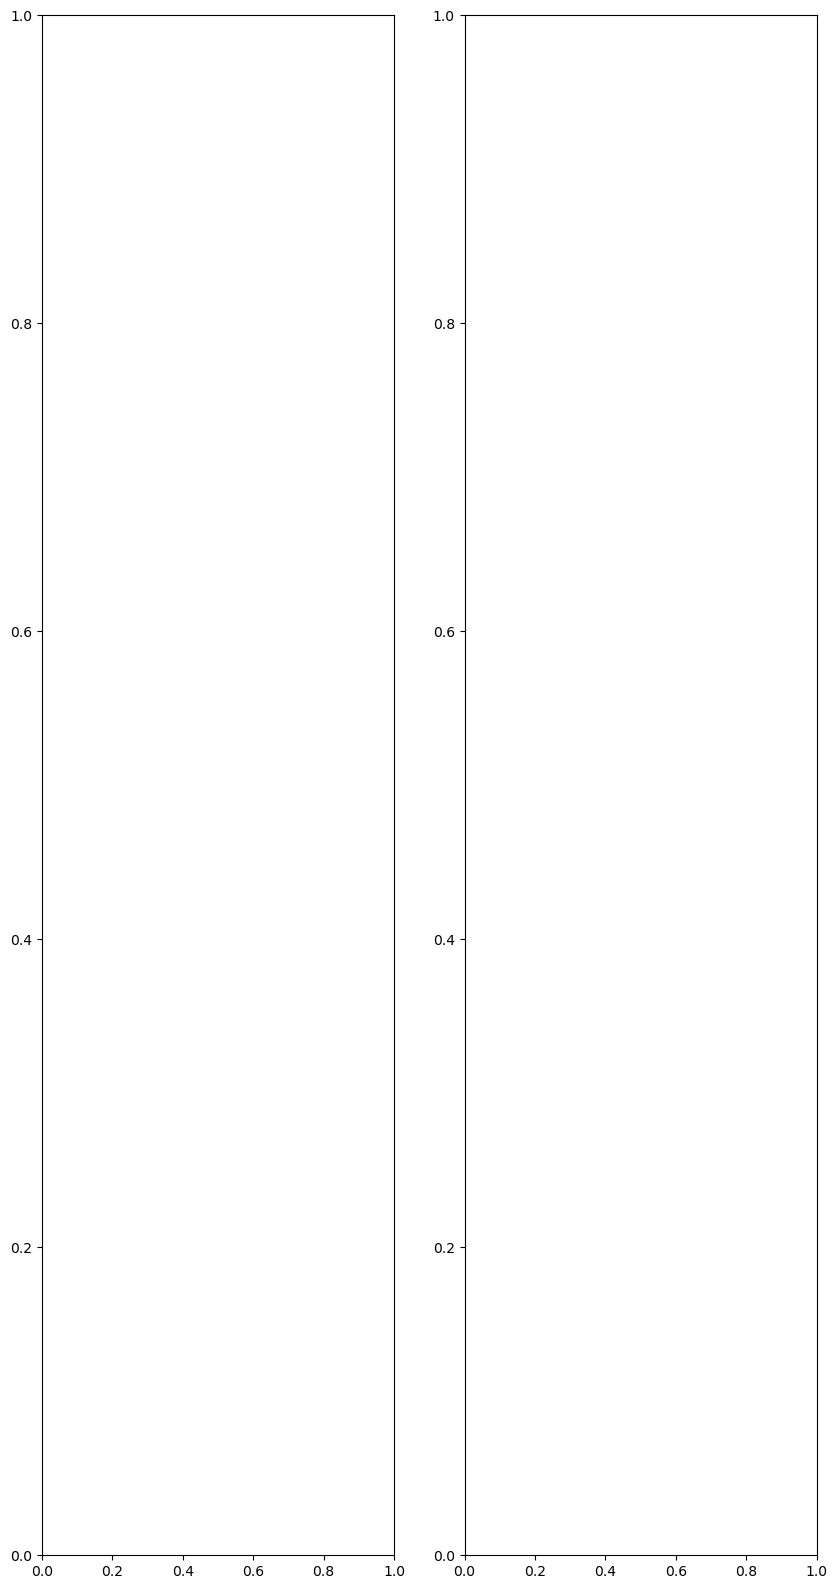

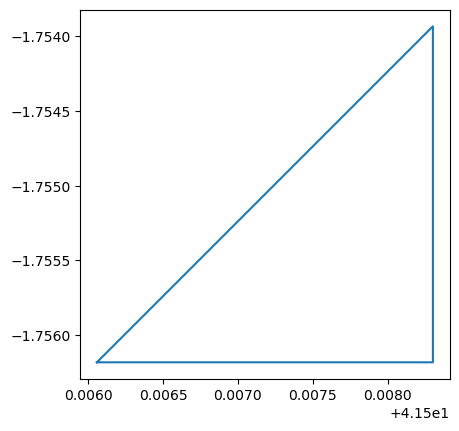

In [101]:
plot_WC_DE_KE(mask_scale = 500, count_threshold = 500)

0


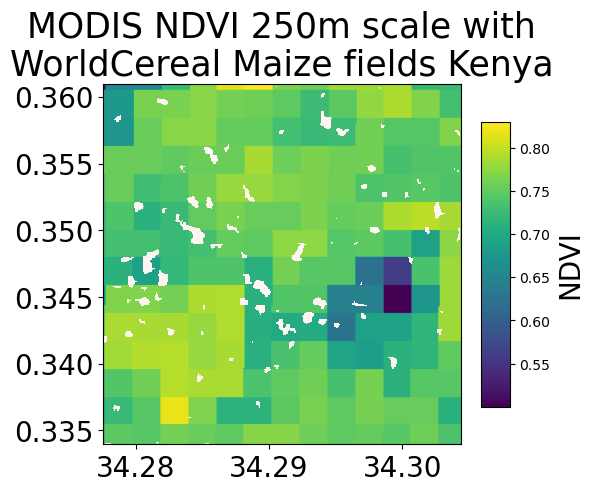

In [34]:
Kenya_coords = np.loadtxt(root_directory + "Saved_files/station_coords_Kenya.csv", {'names': ('lat', 'lon', 'region', 'west', 'south', 'east', 'north'),
                     'formats': ('f8', 'f8', 'S20', 'f8', 'f8', 'f8', 'f8')})
compare_WC_MODIS(coords = Kenya_coords[3:10], savename='Plots/Kenya_WC_MODIS.png')# 

0


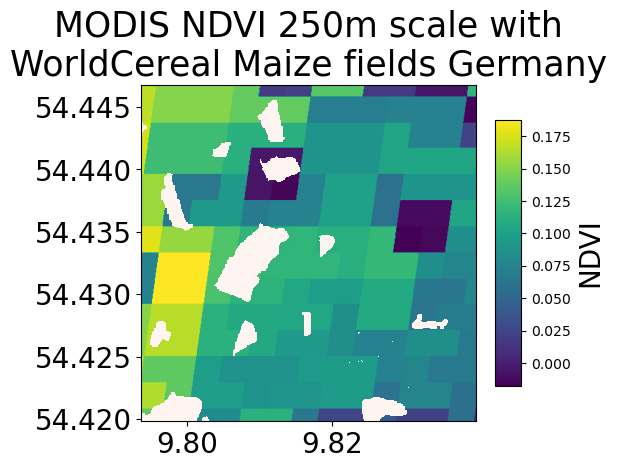

In [37]:
compare_WC_MODIS(savename='Plots/Germany_WC_MODIS.png', title = 'MODIS NDVI 250m scale with\nWorldCereal Maize fields Germany')

In [39]:
def compare_thuenen_Baumert(coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                            buffer_size = 1500, mask_scale = 10, original_scale = 10, count_proportion = 0.9, count_threshold = 0,
                            savename = False, thuenen_year = 2017,
                           Baumert_year = 2017):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    fig, axs = plt.subplots(3, 1, figsize = (30, 15))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        thuenen_mask = ee.Image(f'projects/ee-martinparker637/assets/CTM_GER_{thuenen_year}_rst_v202_COG')
        if crop_type == 'M':
            thuenen_mask = thuenen_mask.select('b1').eq(1300)
        elif crop_type == 'ww':
            eujrc_crop = eujrc.select('classification').eq(1101)
        scale = thuenen_mask.select('b1').projection().nominalScale().getInfo()
        thuenen_mask = thuenen_mask.setDefaultProjection(thuenen_mask.projection(), scale = scale)# scale = original_scale)#, scale=original_scale*scale)
        thuenen_mask = thuenen_mask.updateMask(thuenen_mask)
        #if mask_scale > scale + 50:
        #    thuenen_mask = count_reducer(thuenen_mask).gt(count_threshold)
        region = thuenen_mask.clip(grid_cell).geometry()
        thuenen_vectors = thuenen_mask.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        thuenen_vectors = thuenen_vectors.map(lambda feat: feat.set('mask_used', 0))

        Baumert_mask = ee.Image(f'projects/ee-martinparker637/assets/EU_historic/EU_shares_{Baumert_year}')
        dataset = ee.ImageCollection('MODIS/061/MCD12Q1').filterDate(f'{Baumert_year}-01-01', f'{Baumert_year}-12-31')
        MODISLULCCover = dataset.select('LC_Type5').mosaic()
        MODIS_cropland = MODISLULCCover.eq(7)
        MODIS_cropland = MODIS_cropland.updateMask(MODIS_cropland);
        Baumert_mask = Baumert_mask.updateMask(MODIS_cropland)
        if crop_type == 'M':
            Baumert_mask = Baumert_mask.select('b9').gte(200)
        Baumert_mask = Baumert_mask.updateMask(Baumert_mask)
        region = Baumert_mask.clip(grid_cell).geometry()
        Baumert_vectors = Baumert_mask.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        Baumert_vectors = Baumert_vectors.map(lambda feat: feat.set('mask_used', 1))
        #to_check = ee.Feature(Baumert_vectors.first())
        #print(to_check.geometry().centroid(50).getInfo()['coordinates'])
        Baumert_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")

        Baumert_and_thuenen = thuenen_mask.updateMask(Baumert_mask)
        Baumert_and_thuenen = Baumert_and_thuenen.updateMask(Baumert_and_thuenen)
        Baumert_thuenen_vectors = Baumert_and_thuenen.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        Baumert_thuenen_vectors = Baumert_thuenen_vectors.map(lambda feat: feat.set('mask_used', 2))

        all_together = Baumert_vectors.merge(thuenen_vectors).merge(Baumert_thuenen_vectors)
        all_together.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        fig.colorbar(axs[coord_index].collections[0], label="mask code")
        axs[coord_index].set_title(f'Comparison of masks\n(yellow both, turquoise WC, purple Thuenen)\nlocation {coord_index + 1}')
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

0
1
2


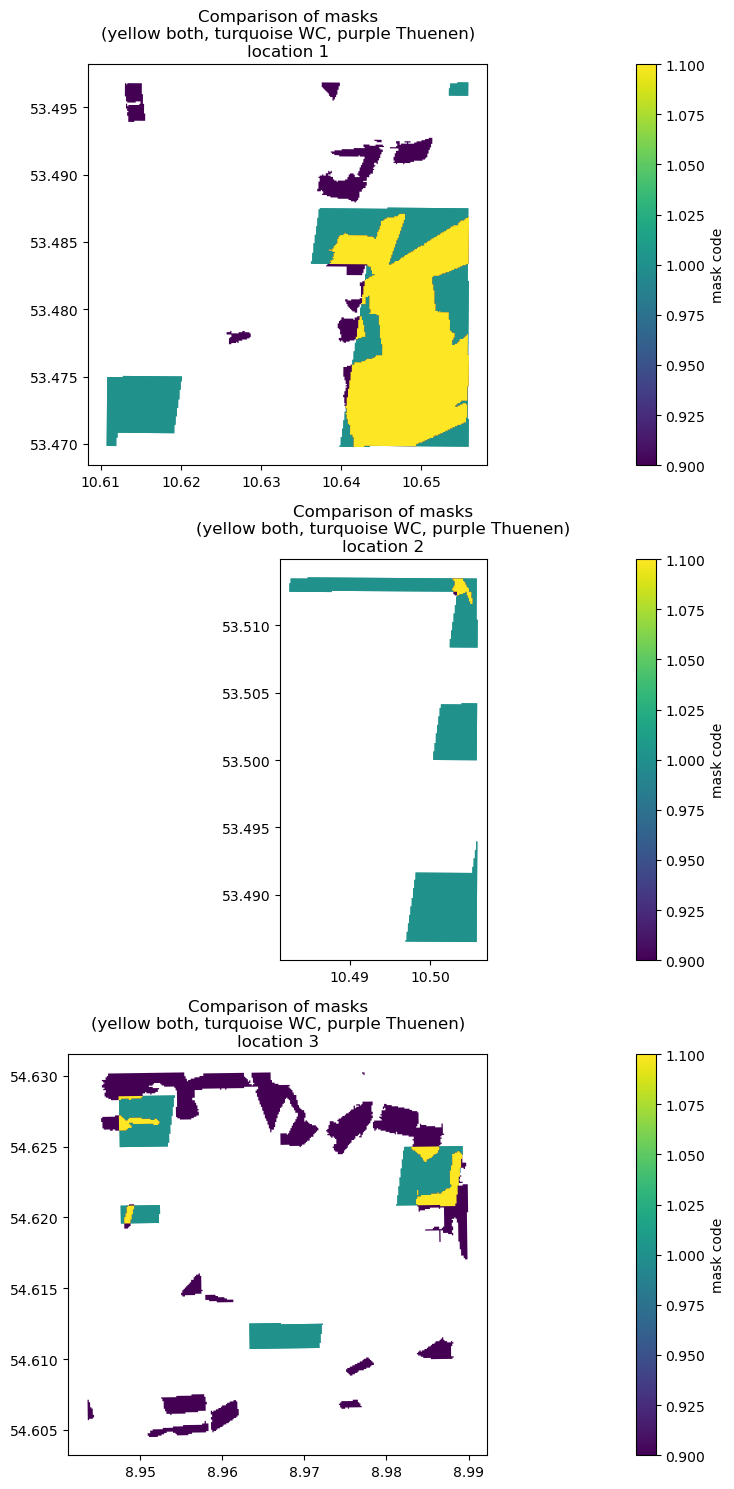

In [41]:
compare_thuenen_Baumert(coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[[6, 9, 10]])

In [4]:
def compare_WC_thuenen(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                            buffer_size = 1500, mask_scale = 10, original_scale = 10, count_proportion = 0.9, count_threshold = 0,
                            savename = False, thuenen_year = 2021):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, axs = plt.subplots(3, 1, figsize = (30, 15))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        thuenen_mask = ee.Image(f'projects/ee-martinparker637/assets/CTM_GER_{thuenen_year}_rst_v202_COG')
        if crop_type == 'M':
            thuenen_mask = thuenen_mask.select('b1').eq(1300)
        elif crop_type == 'ww':
            eujrc_crop = eujrc.select('classification').eq(1101)
        scale = thuenen_mask.select('b1').projection().nominalScale().getInfo()
        thuenen_mask = thuenen_mask.setDefaultProjection(thuenen_mask.projection(), scale = scale)# scale = original_scale)#, scale=original_scale*scale)
        thuenen_mask = thuenen_mask.updateMask(thuenen_mask)
        #if mask_scale > scale + 50:
        #    thuenen_mask = count_reducer(thuenen_mask).gt(count_threshold)
        region = thuenen_mask.clip(grid_cell).geometry()
        thuenen_vectors = thuenen_mask.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        thuenen_vectors = thuenen_vectors.map(lambda feat: feat.set('mask_used', 0))
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
        if mask_scale > scale + 50:
            crop = count_reducer(crop).gt(count_threshold)
        crop = crop.updateMask(crop)
        region = crop.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))

        #Take out update mask if you want just worldcereals
        #WC_and_eujrc = world_cereals.filter(product_codes[crop_type]).mosaic().updateMask(eujrc_crop).select('classification').gte(0)
        WC_and_thuenen = thuenen_mask.updateMask(crop)
        WC_and_thuenen = WC_and_thuenen.updateMask(WC_and_thuenen)
        WC_thuenen_vectors = WC_and_thuenen.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_thuenen_vectors = WC_thuenen_vectors.map(lambda feat: feat.set('mask_used', 2))

        all_together = WC_vectors.merge(thuenen_vectors).merge(WC_thuenen_vectors)
        all_together.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        
        fig.colorbar(axs[coord_index].collections[0], label="mask code")
        axs[coord_index].set_title(f'Comparison of masks\n(yellow both, turquoise WC, purple Thuenen)\nlocation {coord_index + 1}')
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

In [5]:
def compare_crop_masks(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:2],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                      mask_scale=10, buffer_size=1500, savename = False):
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    for mask_index in range(3):
        first_coord = True
        for coord in coords:
            print(coord)
            if mask_index == 0:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 1:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, just_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            elif mask_index == 2:
                IC, vectors = initialise_comparison(instrument = instrument, coord = coord, 
                                                    country = country, crop_type = crop_type, 
                                                    year = year, root_directory = root_directory, combine_eujrc = True,
                                                   mask_scale=mask_scale, buffer_size=buffer_size)
            vectors = vectors.map(lambda feat: feat.buffer(-50))
            masked = csPlus_mask_collection(IC)
            random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 46, 'maxError': 1})#
            ts = getTimeSeriesByRegion(masked,
                reducer = [ee.Reducer.mean(),ee.Reducer.median(), ee.Reducer.max()],
                geometry = random_points,
                bands = ['EVI','NDVI'],#['B4','B8'],
                scale = mask_scale)
            try:
                x = geemap.ee_to_df(ts)
            except:
                continue
            x['date'] = pd.to_datetime(x['date'])
            x = x.where(x['NDVI']!=-9999).dropna()
            name_choices = ['s2 cloud mask', 'google cloud mask']
            xreduced = x.where(x['reducer'] == reducer_code).dropna()
            colour = ['blue', 'red', 'green'][mask_index]
            if first_coord:
                mask_name = ['World cereal',
                             'EUJRC',
                             'World cereal and EUJRC'][mask_index]
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                                     alpha = 0.5, c = colour,
                                     label = f'Using {mask_name} crop masks, {reducer_code} reduced')
                first_coord = False
            else:
                axs[mask_index].plot(xreduced['date'], xreduced['NDVI'], 
                         alpha = 0.5, c=colour)
            axs[mask_index].set_title(mask_name)
            axs[mask_index].tick_params(labelrotation=45)
    fig.legend()
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

In [4]:
#compare_crop_masks(reducer_code = 'mean', coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:10], mask_scale = 10, buffer_size=1500, crop_type = 'M',
#                  N = 1500, year =2020)

In [86]:
def count_reducer(img):
    return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=1200, bestEffort=True)
def percentile_reducer(img):
    return img.reduceResolution(ee.Reducer.percentile([1]),#ee.Reducer.allNonZero(), #ee.Reducer.median(),#ee.Reducer.count(),
                                maxPixels=1200, bestEffort=False)

In [89]:
def try_different_resolution_reducers(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                            buffer_size = 1500, mask_scale = 10, original_scale = 10, count_threshold = 15,
                                     savename = False):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    fig, axs = plt.subplots(1, 3, figsize = (20, 10))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        crop = crop.updateMask(crop)
        #print(world_cereals.first().projection())
        print(world_cereals.first().projection().getInfo()['crs'])
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale=original_scale)
        #crop2 = mask_other(percentile_reducer(crop).gt(0))#
        crop2 = mask_other(count_reducer(crop).gt(count_threshold))
        crop2 = crop2.updateMask(crop2)
        region = crop.clip(grid_cell).geometry()
        region2 = crop2.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': 10,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))
        WC_vectors2 = crop2.reduceToVectors(**{
            'geometry': region2,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        #WC_vectors2 = WC_vectors2.map(lambda feat: feat.buffer(-100))
        WC_vectors2 = WC_vectors2.map(lambda feat: feat.set('mask_used', 2))

        #all_together = WC_vectors2.merge(WC_vectors)
        #all_together.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        crop.geetools.plot(ax=axs[coord_index], bands = ['classification'], 
                           region = region, cmap="viridis")
        crop2.geetools.plot(ax=axs[coord_index], bands = ['classification'], 
                            region = region2, cmap="Reds", scale= mask_scale/100000)
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

0
EPSG:4326


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(
/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


1
EPSG:4326


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(
/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


2
EPSG:4326


/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(
/home/users/wlwc1989/.local/lib/python3.11/site-packages/xee/ext.py:685: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


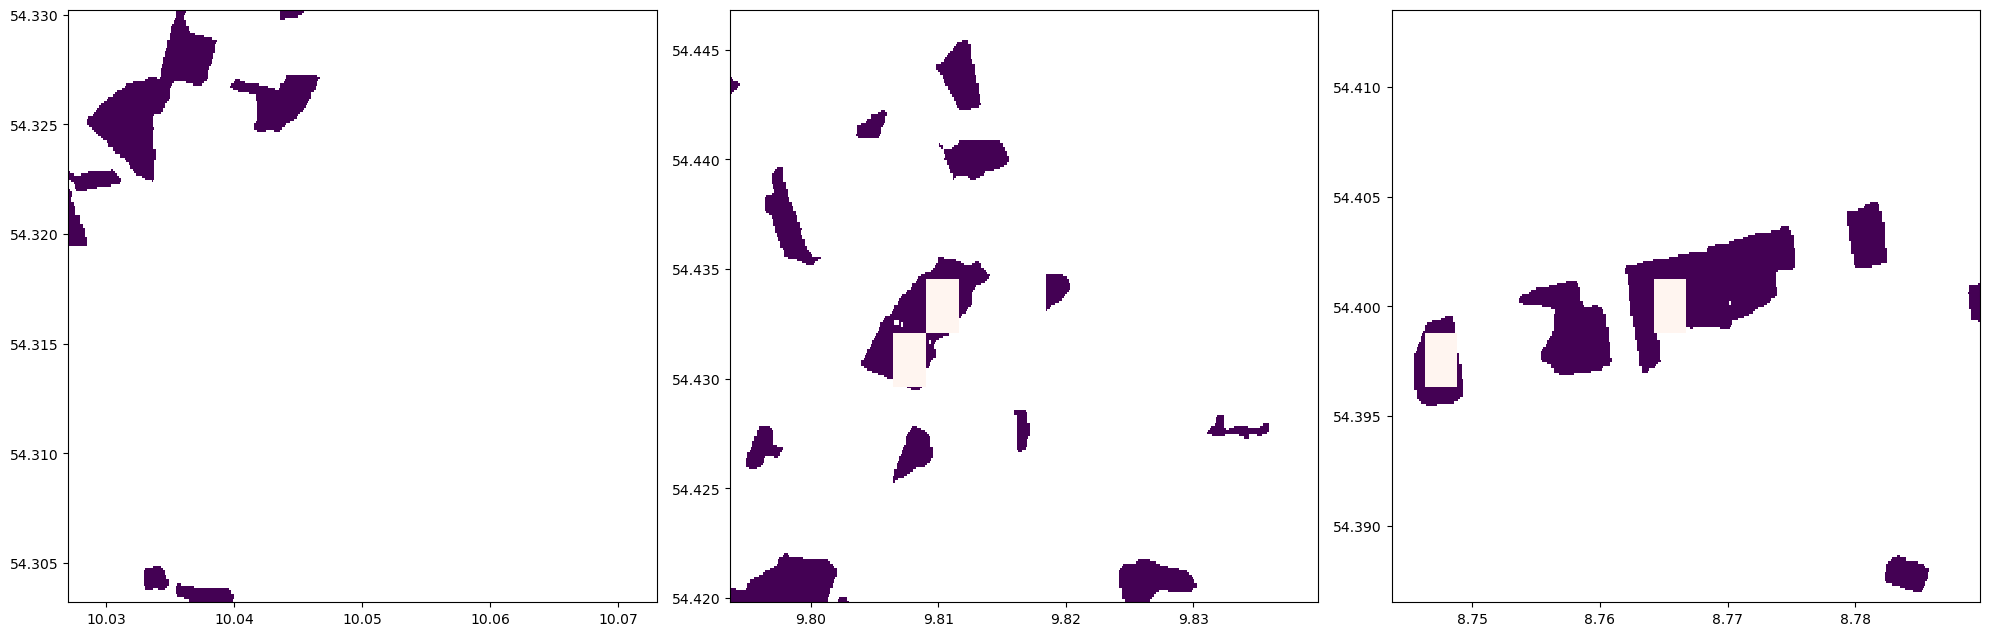

In [96]:
try_different_resolution_reducers(mask_scale = 250, original_scale =10, count_threshold = 800)

In [1]:
#compare_WC_thuenen(buffer_size = 6000, savename = 'Plots/WC_thuenen_2021')

In [2]:
#compare_WC_thuenen(buffer_size = 6000, thuenen_year = 2017, savename = 'Plots/WC_thuenen_2017')

In [13]:
def compare_crop_mask_images(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                       coords = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[0:3],
                      country = 'DE', crop_type = 'M', year = 2019, root_directory = '', N=1, reducer_code = 'median',
                            buffer_size = 1500, mask_scale = 10, original_scale = 10, count_proportion = 0.9, count_threshold = 0,
                            savename = False):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    season_codes = {'M': 'tc-maize-main',
                    'ww': 'tc-wintercereals'}
    #if count_threshold == 0:
    #    count_threshold = count_proportion*((mask_scale/original_scale)**2)
    print(count_threshold)
    def count_reducer(img):
        return img.reduceResolution(ee.Reducer.count(), #ee.Reducer.percentile([90]),#ee.Reducer.median(),#ee.Reducer.count(),
                                    maxPixels=160, bestEffort=True)
    fig, axs = plt.subplots(3, 3, figsize = (20, 20))
    first_coord = True
    for coord_index in range(3):
        print(coord_index)
        coord = coords[coord_index]
        location = ee.Geometry.Point([coord[1],coord[0]]).buffer(buffer_size)
        grid_cell = location.bounds()
        
        eujrc_collection = ee.ImageCollection('JRC/D5/EUCROPMAP/V1').filterDate('2018-01-01', '2023-01-01')
        eujrc = eujrc_collection.mosaic()
        if crop_type == 'M':
            eujrc_crop = eujrc.select('classification').eq(216)
        elif crop_type == 'ww':
            eujrc_crop = eujrc.select('classification').eq(211)
        scale = eujrc_collection.first().select('classification').projection().nominalScale().getInfo()
        eujrc_crop = eujrc_crop.setDefaultProjection(eujrc_collection.first().projection(), scale = scale)# scale = original_scale)#, scale=original_scale*scale)
        eujrc_crop = eujrc_crop.updateMask(eujrc_crop)
        if mask_scale > scale + 50:
            eujrc_crop = count_reducer(eujrc_crop).gt(count_threshold)
        eujrc_crop = eujrc_crop.updateMask(eujrc_crop)
        region = eujrc_crop.clip(grid_cell).geometry()
        eujrc_vectors = eujrc_crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        eujrc_vectors = eujrc_vectors.map(lambda feat: feat.set('mask_used', 0))
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gt(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = scale)#, scale=original_scale*scale)
        if mask_scale > scale + 50:
            crop = count_reducer(crop).gt(count_threshold)
        crop = crop.updateMask(crop)
        region = crop.clip(grid_cell).geometry()
        WC_vectors = crop.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors = WC_vectors.map(lambda feat: feat.set('mask_used', 1))

        #Take out update mask if you want just worldcereals
        #WC_and_eujrc = world_cereals.filter(product_codes[crop_type]).mosaic().updateMask(eujrc_crop).select('classification').gte(0)
        WC_and_eujrc = eujrc_crop.updateMask(crop)
        WC_and_eujrc = WC_and_eujrc.updateMask(WC_and_eujrc)
        WC_eujrc_vectors = WC_and_eujrc.reduceToVectors(**{
            'geometry': region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_eujrc_vectors = WC_eujrc_vectors.map(lambda feat: feat.set('mask_used', 2))

        all_together = WC_vectors.merge(eujrc_vectors).merge(WC_eujrc_vectors)
        all_together.geetools.plot(ax=axs[0, coord_index], property = 'mask_used', cmap="viridis")
        #WC_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type]))#.map(mask_other)
        active_crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification').gte(0)
        specific_crop = world_cereals.mosaic().select('classification').gt(0)
        specific_crop = specific_crop.updateMask(specific_crop)
        active_crop = active_crop.setDefaultProjection(world_cereals.first().projection(), scale = 10)#, scale=original_scale*scale)
        specific_crop = specific_crop.setDefaultProjection(world_cereals.first().projection(), scale = 10)#, scale=original_scale*scale)
        #crop = count_reducer(crop).gt(count_threshold)
        #crop = crop.updateMask(crop)
        active_region = active_crop.clip(grid_cell).geometry()
        specific_region = specific_crop.clip(grid_cell).geometry()
        WC_vectors_active = active_crop.reduceToVectors(**{
            'geometry': active_region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors_active = WC_vectors_active.map(lambda feat: feat.set('mask_used', 1))
        WC_vectors_specific = specific_crop.reduceToVectors(**{
            'geometry': specific_region,
            'scale': mask_scale,
            'maxPixels': 1e13,
            'bestEffort':True,
            'eightConnected': False,
            })
        WC_vectors_specific = WC_vectors_specific.map(lambda feat: feat.set('mask_used', 2))
        alltogether_new = WC_vectors_active.merge(WC_vectors_specific)
        alltogether_new.geetools.plot(ax=axs[2, coord_index], property = 'mask_used', cmap="viridis")
        
        world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100').filter(ee.Filter.eq('season', season_codes[crop_type])).map(mask_other)
        crop = world_cereals.filter(product_codes[crop_type]).mosaic().select('classification')#.gte(0)
        scale = world_cereals.first().select('classification').projection().nominalScale().getInfo()
        crop = crop.setDefaultProjection(world_cereals.first().projection(), scale = 10)#, scale=original_scale*scale)
        crop = count_reducer(crop)
        #crop = crop.gt(20)
        crop.geetools.plot(bands = ['classification'], ax = axs[1, coord_index], region=location, 
                                               crs = world_cereals.first().projection().getInfo()['crs'],
                                               cmap="viridis", scale = mask_scale/100000)
        
        #WC_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        #eujrc_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        #WC_eujrc_vectors.geetools.plot(ax=axs[coord_index], property = 'mask_used', cmap="viridis")
        
        #crop.geetools.plot(bands = ['classification'], ax = axs[coord_index + 2], region=location, scale = mask_scale/10000)
        #eujrc_maize.geetools.plot(bands = ['classification'], ax = axs[coord_index + 1], region=location, scale = mask_scale/10000)
        #WC_and_eujrc.geetools.plot(bands = ['classification'], ax = axs[coord_index], region=location,cmap="Purples")
        fig.colorbar(axs[0, coord_index].collections[0], label="mask code")
        axs[0, coord_index].set_title(f'Comparison of masks\n(yellow both, turquoise WC, purple eujrc)\nlocation {coord_index + 1}')
        fig.colorbar(axs[1, coord_index].images[0], label="count of pixels that fit category")
        axs[1, coord_index].set_title(f'Counts of crop in pixel for WC\n(to check threshold)\nlocation {coord_index + 1}')
        fig.colorbar(axs[2, coord_index].collections[0], label="active cropland and crop specific")
        axs[2, coord_index].set_title(f'Comparison of WC active cropland and crop specific\n(yellow crop specific, purple active cropland)\nto check aggregation is not just active cropland') 
    fig.tight_layout()
    if savename != False:
        fig.savefig(savename, bbox_inches = 'tight')

In [293]:
def worldcereal_to_check(instrument = 'COPERNICUS/S2_SR_HARMONIZED',
                     coord = np.loadtxt(root_directory + "Saved_files/station_coords.csv", delimiter=',')[1],
                     country = 'DE', crop_type = 'M', year = 2019, root_directory = '',
                     reducer_code = 'median', mask_scale = 250, buffer_size = 5000):
    country_codes = {'DE': 93,
                     'KEN': 133}
    product_codes = {'M': 'product == "maize"',
                     'ww': 'product == "wintercereals"'}
    IC, vectors = initialise_comparison(instrument = instrument, coord = coord, country = country, crop_type = crop_type, year = year, root_directory = root_directory, mask_scale = 1000)
    fig, ax = plt.subplots()
    world_cereals = ee.ImageCollection('ESA/WorldCereal/2021/MODELS/v100')
    crop = world_cereals.filter(product_codes[crop_type]).map(lambda image: image.updateMask(image.neq(0))).mosaic().select('classification').gt(0)
    crop = crop.updateMask(crop)
    N = 100
    random_points = ee.FeatureCollection.randomPoints(**{'region': vectors, 'points': N, 'seed': 43, 'maxError': 1})
    box_width = 0.02
    location = ee.Geometry.BBox(coord[1] - box_width, coord[0] - box_width, coord[1] + box_width, coord[0] + box_width)
    feats = ee.FeatureCollection([ee.Feature(random_points.geometry().buffer(10))])
    grid_cell_lon = coord[1]
    grid_cell_lat = coord[0]
    grid_cell = ee.Geometry.Point(grid_cell_lon, grid_cell_lat).buffer(buffer_size).bounds()
    region = crop.clip(grid_cell).geometry()
    vectors = crop.reduceToVectors(**{
        'geometry': location, #region,
        'scale': mask_scale,
        'maxPixels': 1e13,
        'bestEffort':True,
        'eightConnected': False,
        'geometryInNativeProjection': False,
        'geometryType':'bb'
        })#.map(lambda x: x.buffer(-20))
    crop.geetools.plot(bands = ['classification'], fc=vectors, ax = ax, region=location,cmap="viridis", #fc=points, 
                              color="red", scale = mask_scale/100000)
    